# Teorica

Lo que queda es replicar con Bayes lo que vimos de manera frecuentista. ()

Vamos a ver una regresion lineal 1D y como usar pymc.

In [19]:
import pymc as pm
import numpy as np
import arviz as az

true_proba = 0.3
n_draws = 1000
exitos = np.random.binomial(n_draws, true_proba)
print(exitos)


306


In [20]:
with pm.Model() as binomial_model:
    # cual es el parametro que quiero ajustar? -> p
    p = pm.Uniform('p', 0, 1) # prior no info
    # lo que conecta al prior con posterior es la likelihood: exitos (?)
    likelihood = pm.Binomial('likelihood', n= n_draws, p=p, observed= exitos)
    # con esto ya puedo samplear
    trace = pm.sample(2_000) # chains = 2

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [p]


c:\Users\nazar\AppData\Local\Programs\Python\Python312\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 20 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [13]:
binomial_model

     p ~ Uniform(0, 1)
exitos ~ Binomial(1e+03, p)

array([[<Axes: title={'center': 'p'}>, <Axes: title={'center': 'p'}>]],
      dtype=object)

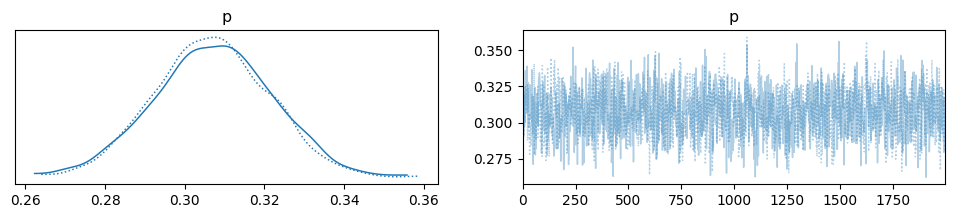

In [21]:
az.plot_trace(trace)

Genera una serie de obs de una distr desconocida  
Saca muchas obs para que quede la distr que esta por detras

El grafico de la izquierda es la traza de la cadena de Markov  
El de la derecha es la traza como histograma  
Nota: se ven mas de un grafico porque se hacen multiples cadenas  

Si hacemos un histograma con los datos del grafico de la derecha sale el grafico de la posterior.  

A medida que aumente la cantidad de samples me queda una p mejor definida (probar)

En general se decide usar 2000 samples por cadena

El TCL me dice:

$P(p)$ = media de la distr  
error = sigma/raiz(n)

el problema con esto es que lo que vemos ya es la posterior.  
no puedo sacar estadisticos de ahi.

El TCL serviria para calcular la media de la distr

Vemos que $p$ dio parecido al true_proba

In [22]:
trace.posterior["p"]

<xarray.DataArray 'p' (chain: 2, draw: 2000)> Size: 32kB
array([[0.32968878, 0.33067769, 0.32797156, ..., 0.31053442, 0.29053127,
        0.30892943],
       [0.30026152, 0.29637203, 0.29055534, ..., 0.28201742, 0.28134202,
        0.28615916]])
Coordinates:
  * chain    (chain) int32 8B 0 1
  * draw     (draw) int32 8kB 0 1 2 3 4 5 6 ... 1994 1995 1996 1997 1998 1999

### Lo mismo para una Normal

#### conociendo sigma

In [30]:
n_samples = 1_000
mu = 0
sigma = 1
samples = np.random.normal(mu, sigma, size = n_samples)

(array([  8.,  28.,  85., 131., 235., 214., 162.,  86.,  38.,  13.]),
 array([-2.99774984, -2.41366501, -1.82958017, -1.24549534, -0.6614105 ,
        -0.07732566,  0.50675917,  1.09084401,  1.67492884,  2.25901368,
         2.84309851]),
 <BarContainer object of 10 artists>)

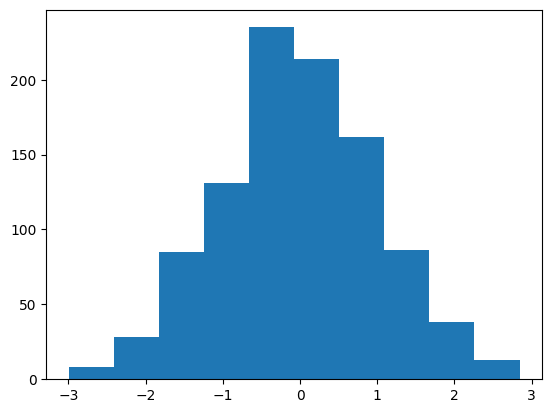

In [31]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.hist(samples)

esos son mis puntos observados

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [mu]


c:\Users\nazar\AppData\Local\Programs\Python\Python312\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 8_000 draw iterations (4_000 + 32_000 draws total) took 51 seconds.


array([[<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>]],
      dtype=object)

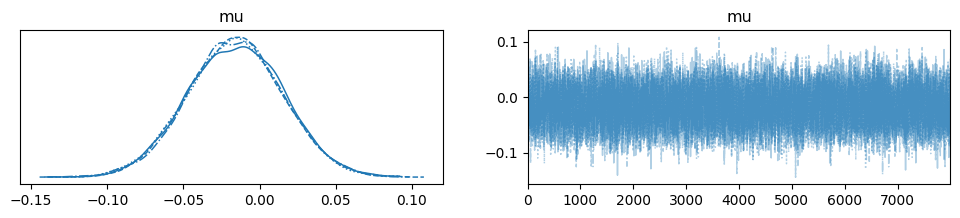

In [32]:
with pm.Model() as normal_model:
    mu = pm.Uniform('mu', -1000, 1000) # el prior no informativo de mu es impropio, va de -inf a inf
    #mu = pm.Flat("mu")  # tambien se puede asi
    likelihood = pm.Normal('likelihood', mu= mu, sigma= 1, observed= samples)
    trace = pm.sample(8_000, chains= 4)
az.plot_trace(trace)

Se acerco bastante.  
Con flat() deberia dar mejor.  
Lo ideal seria tener un prior informativo como mu = normal(0, 10)

#### sigma desconocido

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [mu, sigma]


c:\Users\nazar\AppData\Local\Programs\Python\Python312\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 8_000 draw iterations (4_000 + 32_000 draws total) took 110 seconds.


array([[<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

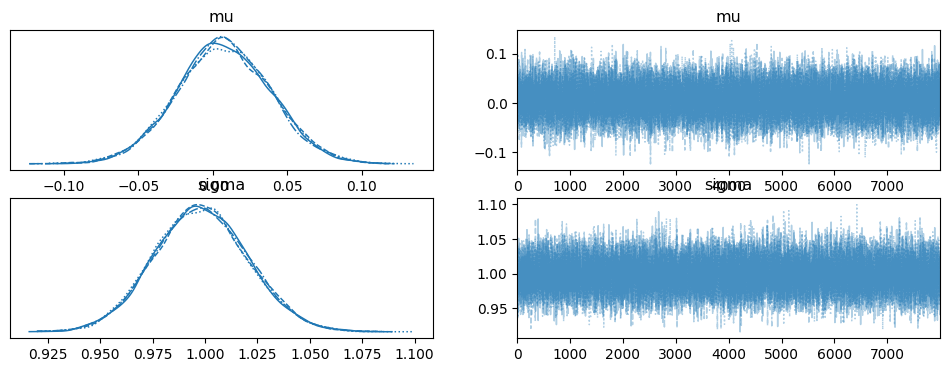

In [34]:
n_samples = 1_000
mu = 0
sigma = 1
samples = np.random.normal(mu, sigma, size = n_samples)
with pm.Model() as normal_model:
    # mu = pm.Flat("mu")
    mu = pm.Uniform("mu", -1000, 1000) 
    sigma = pm.Uniform("sigma", 0, 1_000)
    likelihood = pm.Normal('likelihood', mu= mu, sigma= sigma, observed= samples)
    trace = pm.sample(8_000, chains= 4)
az.plot_trace(trace)

### Regresion Lineal

Generamos data sintetica

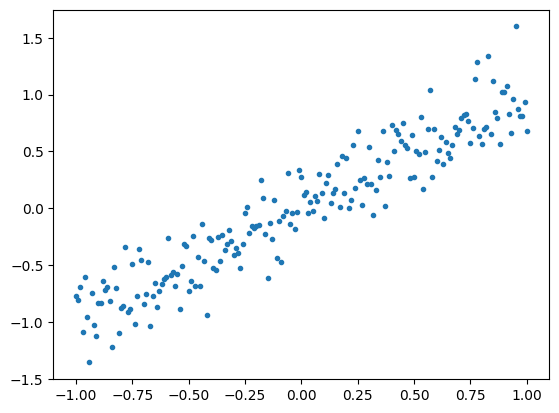

In [41]:
true_intercept = 0
true_slope = 1
true_sigma = 0.2

x = np.linspace(-1, 1, 201)
y = true_intercept + true_slope * x + np.random.normal(0, true_sigma, size= 201)
# y = Normal(mu, sigma)
# mu = intercept + slpoe * x

fig, ax = plt.subplots()
ax.plot(x,y, ".")

In [ ]:
with pm.Model() as linear_model:
    # priors
    #sigma = pm.HalfFlat("sigma") # todos los positivos
    sigma = pm.Uniform("sigma", 0, 1000)
    #intercept = pm.Flat("intercept")
    intercept = pm.Uniform("intercept", -1000, 1000)
    #slope = pm.Flat("slope")
    slope = pm.Uniform("slope", -1000, 1000)
    # funcion de enlace
    mu = intercept + x * slope
    # data
    likelihood = pm.Normal("likelihood", mu=mu, sigma=sigma)
    trace = pm.sample(2_000)
linear_model

In [ ]:
az.plot_trace(trace)
plt.gcf().tight_layout()

In [ ]:
trace.posterior

Podria graficar todos los 32000 ajustes  
Pero voy a elejir solo 1000

In [ ]:
fig, ax = plt.subplots()
ax.plot(x,y, ".")
n_fits = 1000
for _ in range(n_fit):
    chain = np.random.randint(4)
    draw = np.random.randint(8000)
    intercept = trace.posterior.interceot.values[chain, draw]
    slope = trace.posterior.slope.values[chain, draw]
    ax.plot(x, intercept + slope * x, alpha=0.2, color = "gray")

Recordemos penalizacion:  

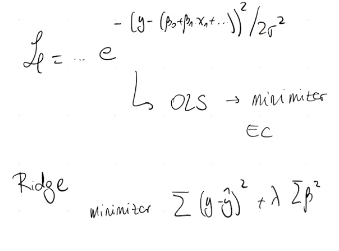

modificabamos la likelihood

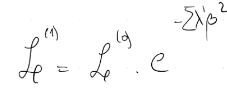

es como ponerle un prior

#### Ridge

In [ ]:
# L(1) = L(0) * exp(-k * sum(b^2))
with pm.Model() as ridge_model:
    # priors
    #sigma = pm.HalfFlat("sigma") # todos los positivos
    sigma = pm.Uniform("sigma", 0, 1000)
    #intercept = pm.Flat("intercept")
    intercept = pm.Uniform("intercept", -1000, 1000)
    slope = pm.Normal("slope", mu = 0, sigma = 0.1) # espero que este cerca de 0
    # funcion de enlace
    mu = intercept + x * slope
    # data
    likelihood = pm.Normal("likelihood", mu=mu, sigma=sigma)
    trace = pm.sample(2_000)
ridge_model

In [ ]:
az.plot_trace(trace)
plt.gcf().tight_layout()

# Practica